In [1]:
!pip install wordcloud
!pip install contractions


In [1]:
import pandas as pd
import re
import contractions
import wordcloud
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

import glob 


STOPWORDS = stopwords.words('english')
STEMMER = PorterStemmer()
PUNCTUATIONS = r'[\!\(\)\-\[\]\{\}\;\:\"\\\,\<\>\.\/\?\@\#\$\%\^\&\*\_\~]'


In [2]:

def getCSVData(file):
    df = pd.read_csv(file)
    show = file.split("/")[-1][:-4]
    data = df.loc[:, ["text"]]
    data["text_clean"] = data.text.apply(lambda x: cleanText(x, show))
    data["hashtags"] = data.text.apply(lambda x: getHashtags(x, show.replace(" ", "")))
    return data


def getJSONData(file):
    df = pd.read_json(file, lines=True)
    show = file.split("/")[-1][:-5]
    data = df[df.lang == "en"].loc[:, ['content']]
    data["text_clean"] = data.content.apply(lambda x: cleanText(x, show))
    data["hashtags"] = data.content.apply(lambda x: getHashtags(x, show.replace(" ", "")))
    return data

In [3]:
def cleanText(tweet, show_name): 
    STOPWORDS_THIS = STOPWORDS + []
    STOPWORDS_THIS.extend(["netflix","episode", show_name] + show_name.split())
    tweet_text = tweet.split()

    # remove hashtags
    tweet_no_hash = [t.lower() for t in tweet_text if not re.match(r"#.\w+", t)]
    
    # remove punctuation
    tweet_replace_sym = [re.sub(PUNCTUATIONS, "",t) for t in tweet_no_hash]

    #get words only and fix contarctions
    tweet_words = [contractions.fix(t.lower()) for t in tweet_replace_sym if re.match(r"(\w+)", t)]
    
    words = ' '.join(tweet_words)
    tweet_words =  words.split()

    #remove stop words, stem words

    tweet_no_stop = [STEMMER.stem(t) for t in tweet_words if t not in STOPWORDS_THIS]


    #remove links
    tweet_remove_link = [t for t in tweet_no_stop if not re.match(r"^http", t)]
    
    #remove from stop words 
    
    return ' '.join(tweet_remove_link)
    
def getHashtags(tweet, show_name): 
    tweet_text = tweet.split()
    hashtags = [t.lower() for t in tweet_text if re.match(r"#.\w+", t)]
    remove_stop_hash = [hashtag for hashtag in hashtags if show_name not in hashtag and "netflix" not in hashtag and hashtag[1:].encode().isalpha()]
    tweet_replace_sym = [re.sub(PUNCTUATIONS, "",t) for t in remove_stop_hash]
    return ' '.join(tweet_replace_sym)


In [4]:

def genWC(df, show, wc_type, mask_type):
    WC_DIR = "./project/static/wc"
    MASK_DIR = "./project/static/mask"

    from PIL import Image
    stopwords = set(STOPWORDS)

    mask = np.array(Image.open(f"{MASK_DIR}/{show}_mask.{mask_type}"))

    image_colors = ImageColorGenerator(mask)
    wordcloud = WordCloud(width = 3000, height = 2000, stopwords=STOPWORDS, background_color="white", max_words=1000, mask=mask).generate(' '.join(df))

    # create word cloud image
    plt.figure()
    # plt.figure(figsize=(39.714, 18.759), dpi=300)
    plt.axis("off")
    im2 = plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    im1 = plt.imshow(mask, alpha = 0.075)

    # store to file
    plt.savefig(f"{WC_DIR}/{show}_{wc_type}.png", dpi=300)
    # plt.show()


# genWC(data.text_clean, "squidgame_text")
# genWC(data.hashtags, "squidgame_hashtags")

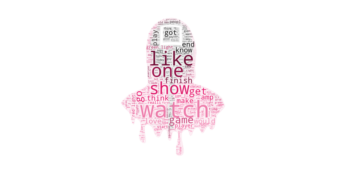

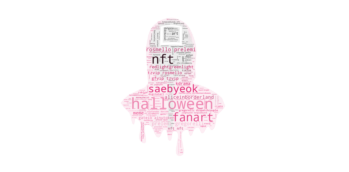

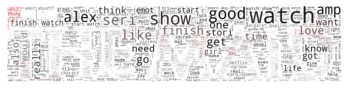

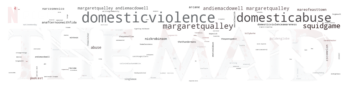

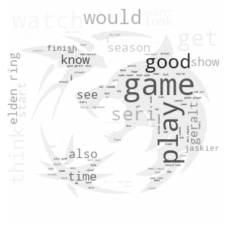

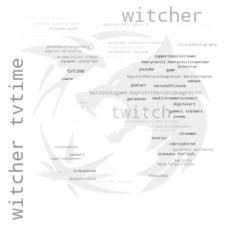

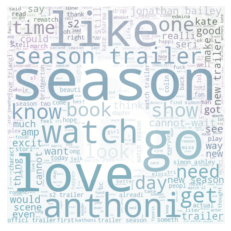

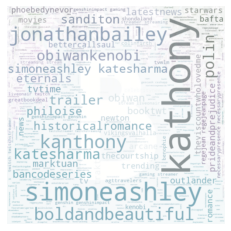

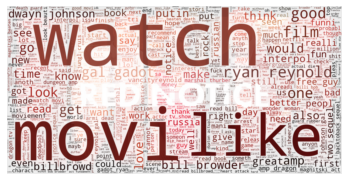

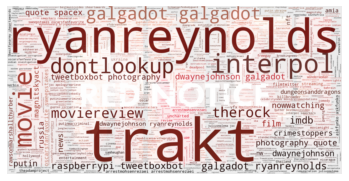

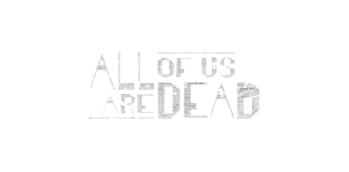

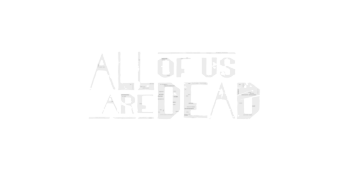

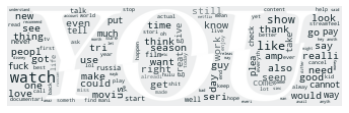

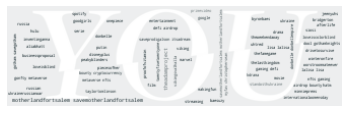

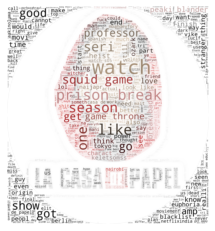

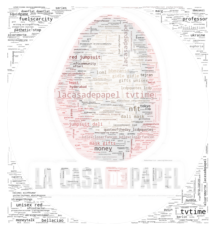

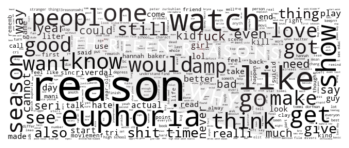

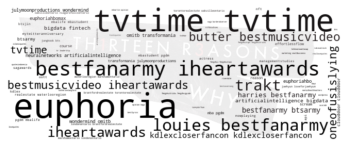

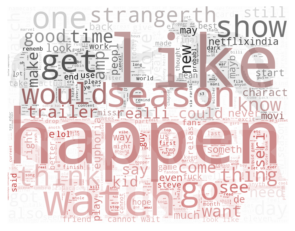

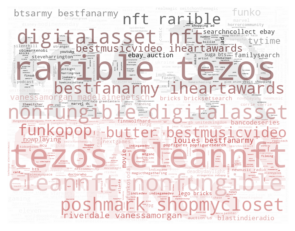

In [5]:
FILE_DIR = "Data/tweets/"
mask_file_types = {"13 reasons why": "png", "all of us are dead": "png", "bridgerton": "png", "maid": "png", "money heist":"png", "red notice": "jpg", "squid game": "png", "stranger things":"jpg", "the witcher":"jpg", "you": "png" }
csv_files = glob.glob(f"Data/tweets/*.csv")
for file in csv_files: 
    data = getCSVData(file)
    show = file.split("/")[-1][:-4]
    genWC(data.text_clean, show, "text", mask_file_types[show])
    genWC(data.hashtags, show, "hashtags", mask_file_types[show])  

json_files = glob.glob(f"Data/tweets/*.json")
for file in json_files:
    data = getJSONData(file)
    show = file.split("/")[-1][:-5]
    genWC(data.text_clean, show, "text", mask_file_types[show])
    genWC(data.hashtags, show, "hashtags", mask_file_types[show])  